# Revision history of Wikipedia articles

### Inspired by Aaron Swartz's "Who writes Wikipedia?" 

Work in progress...

In [1]:
# Import classes used in this notebook

import urllib.request
import re
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
def GetRevisions(pageTitle):
    
    # Format is xml because it's preferred for 'rvcontinue'. See https://www.mediawiki.org/wiki/API:Revisions
    url = "https://en.wikipedia.org/w/api.php?action=query&format=xml&prop=revisions&rvprop=timestamp|user|size&rvlimit=500&titles=" + pageTitle
    revisions = [] # list of all accumulated revisions
    next = '' # information for the next request
    
    while True:
        response = urllib.request.urlopen(url + next).read().decode('utf-8') # web request, error without .decode('utf-8')
        revisions += re.findall('<rev [^>]*>', response) # adds all revisions from the current request to the list

        cont = re.search('<continue rvcontinue="([^"]+)"', response)
        if not cont: # break the loop if 'continue' element missing
            break

        next = "&rvcontinue=" + cont.group(1) # gets the revision Id from which to start the next request

    return revisions;

# Could the RegEx string parsing from result_to_dataframe() be incorporated into this already?

# Insert Wikipedia page title below

Insert the article title of your choosing in the GetRevisions() function below. 

Check you have the corroct page title! It's case sensitive and spaces are underscores. You can take the title from the page URL. 

For example, for https://en.wikipedia.org/wiki/Aaron_Swartz the page title is "Aaron_Swartz".

So to get the revisions history for the article put it into the function in the cell below in quotation marks like so:

```python
GetRevisions("Aaron_Swartz")
```

Then run all subsequent cells or click 'Kernel' in the menu bar and select 'Restart Kernel and Run All Cells...'

Depending on the article size it may take several seconds to gather all the data.

In [3]:
revisions = GetRevisions("Diabetes_mellitus") 

# Wikipedia article titles are case sensitive and spaces are underscores
# Make sure the title corresponds to Wikipedia's title - you can take it from the URL
# e.g. "Diabetes" is actually "Diabetes_mellitus", "Diabetes" returns differnt results

### Number of article revisions to date:

In [4]:
# API returns a list of strings so the number of items in the list == number of revisions
len(revisions) 

7396

In [5]:
def result_to_dataframe():
    
    """Loops over the the 'revisions' list and extracts
        user, timestamp, revision size values. 
    Returns: 
        pandas dataframe"""
    
    # Initiate an empty list of list for future dataframe
    data = [[],[],[]]
    # These will be column headers of the returned dataframe
    headers = ['user', 'time', 'size']
    
    for i in revisions:
        
        # Find username to extract 
        userMatch = re.search('user="(.+?)"', i)
        # Catch missing values throwing AttributeError
        if userMatch is not None:
            user = userMatch.group(1)
        else:
            user = ""
        # Add result to the first list of lists in 'data'
        data[0].append(user)
        
        # Find timestamp to extract
        timeMatch = re.search('timestamp="(.+?)"', i)
        # Catch missing values throwing AttributeError
        if timeMatch is not None:
            time = timeMatch.group(1)
        else:
            time = "" # how is this handled in the chart?
        # Add result to the second list of lists in 'data'
        data[1].append(time)
        
        # Find revision size to extract
        sizeMatch = re.search('size="(.+?)"', i)
        # Catch missing values throwing AttributeError
        if sizeMatch is not None:
            size = sizeMatch.group(1)
        else:
            size = "" # how to handle this is the chart?
        # Add result to the third list of lists in 'data'
        data[2].append(size)
        
    return pd.DataFrame(dict(zip(headers, data))) 
    
    # NOTE: Alternative return: pd.DataFrame(data=data).T
    # But simply transposing the dataframe with the transpose method
    # would only work if we didn't assign the headers in the same step
    # therefore the (dict(zip(____,____))) is preferable here

In [6]:
# Can this be incorporated into the 'return' in the function above?
df = result_to_dataframe()
df.set_index('time', inplace=True);
df.index = pd.to_datetime(df.index, infer_datetime_format=True)
df['size'] = pd.to_numeric(df['size']) # size is article length after revision, not size of revision
df.sort_index();
df['edit'] = df['size'] - df['size'].shift(-1)

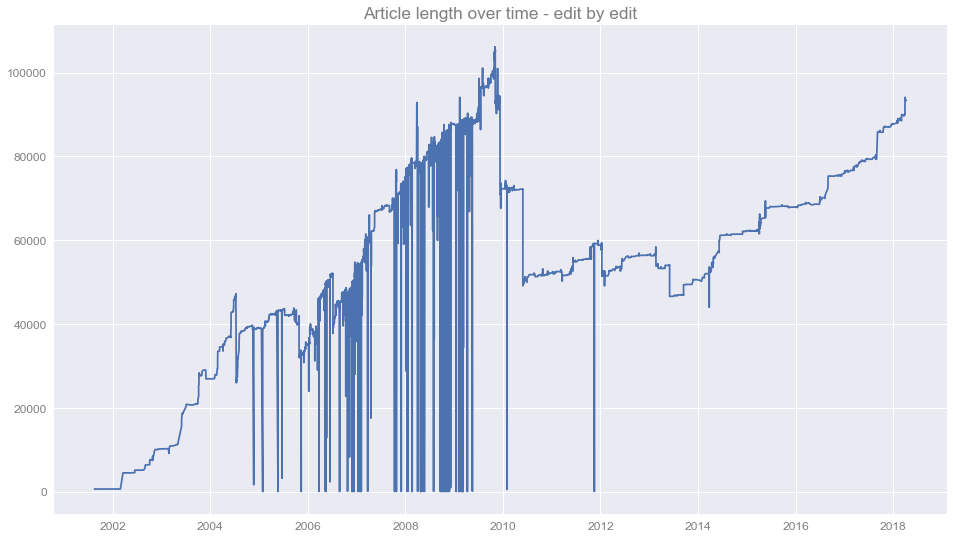

In [17]:
# Just some formatting parameters
plt.figure(figsize=(16,9)) # Increase the plot size to 16 x 9
plt.title('Article length over time - edit by edit', color='grey', size='xx-large') 
plt.xticks(size='large', color='grey') # Grey color to show on my dark theme and also white background
plt.yticks(size='large', color='grey') # Units are bytes

y = df['size']
x = df.index

plt.plot(x,y);

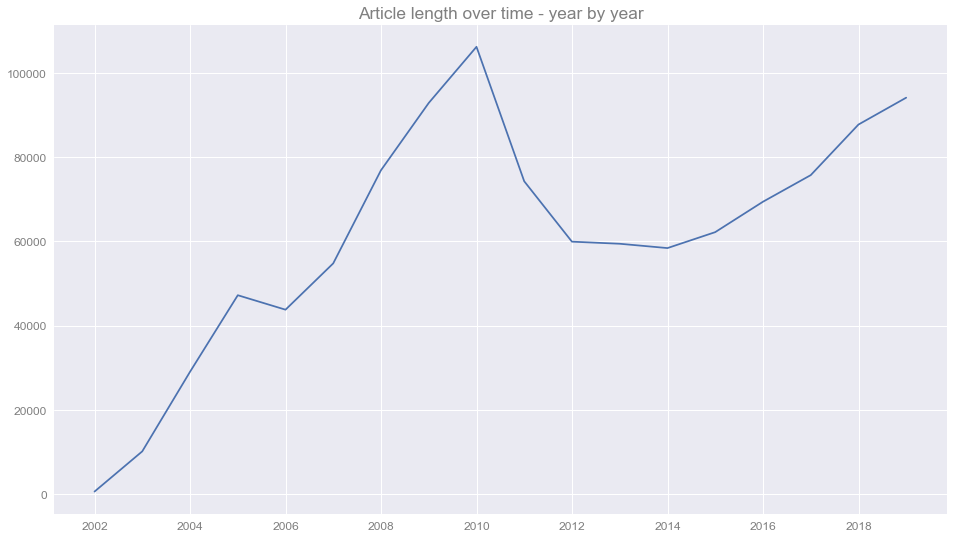

In [18]:
df2 = df.resample('A').max()

plt.figure(figsize=(16,9)) # Increase the plot size to 16 x 9
plt.title('Article length over time - year by year', color='grey', size='xx-large') 
plt.xticks(size='large', color='grey') # Grey color to show on my dark theme and also white background
plt.yticks(size='large', color='grey') # Units are bytes

y2 = df2['size']
x2 = df2.index

plt.plot(x2,y2);

# Idea: Add four or more figures: actual, H, D, W, M, A
# Or H to A in different colour lines in the same figure

### Top ten vandalisms

In [9]:
df.sort_values(by=['edit'],ascending=True, inplace=False).head(10)

,size,user,edit
time,,,
2009-04-08 18:56:23,1,151.200.18.228,-88883.0
2009-03-08 00:51:19,0,24.21.253.146,-88717.0
2009-03-04 17:10:07,20,65.18.49.39,-88685.0
2009-03-04 10:55:17,51,Parkicar,-88633.0
2009-05-16 06:25:01,81,75.2.140.145,-88372.0
2009-02-27 19:47:30,0,70.184.35.16,-88013.0
2009-02-27 16:35:41,14,75.162.72.204,-87886.0
2008-11-24 21:31:55,0,76.125.5.150,-87408.0
2009-02-12 05:43:18,21,70.67.197.172,-87383.0


### Reversals of vandalisms

In [10]:
df.sort_values(by=['edit'],ascending=False, inplace=False).head(10)

,size,user,edit
time,,,
2009-04-08 18:56:36,88884,Kingpin13,88883.0
2009-03-08 00:51:29,88717,ClueBot,88717.0
2009-03-04 17:10:21,88705,ClueBot,88685.0
2009-03-04 10:55:35,88684,Camw,88633.0
2009-05-16 06:25:08,88453,ClueBot,88372.0
2009-02-27 19:47:42,88013,Shawn in Montreal,88013.0
2009-02-27 16:35:53,87900,ClueBot,87886.0
2008-11-24 21:32:05,87408,Mifter,87408.0
2009-02-12 05:43:30,87404,Camw,87383.0


### Top contributors v top editors (not bots, not vandalism reversals) 

TBC